# F1 Race Analysis

### Import Libraries

In [23]:
import os
import sys
import fastf1
try:
    fastf1.Cache.enable_cache(sys.path[0]+"/fastf1_cache") 
except:
    os.makedirs(sys.path[0]+"/fastf1_cache")
    fastf1.Cache.enable_cache(sys.path[0]+"/fastf1_cache") 
from fastf1 import plotting
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
import datetime
import seaborn as sns
sns.set_style("darkgrid")
import pandas as pd
import numpy as np
from windrose import WindroseAxes
pd.set_option('display.max_columns', None)

### Load Race(Input Race Name and Year)

In [24]:
# input session and year
year = 2023
location = 'Belgium'

# get session
"""
    session identifier:
    'FP1', 'FP2', 'FP3', 'Q', 'S', 'SQ', 'SS', 'R
    'Practice 1', 'Practice 2', 'Practice 3', 'Sprint Qualifying', 'Sprint', 'Sprint Shootout', 'Qualifying', 'Race'
"""

race = fastf1.get_session(year, location, 'R')
race.load(weather=True)

core           INFO 	Loading data for Belgian Grand Prix - Race [v3.0.0]
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written

### Load Dataframe and Preprocessing

In [25]:
# load race laps
race_name = race.event.OfficialEventName
df = race.laps

# load dataframe of df (by Final Position in ascending order)
df = df.sort_values(by=['LapNumber','Position'], ascending=[False, True]).reset_index(drop=True)

# fill in empty laptime records and convert to seconds
df.LapTime = df.LapTime.fillna(df['Sector1Time']+df['Sector2Time']+df['Sector3Time'])
df.LapTime = df.LapTime.dt.total_seconds()
df.Sector1Time = df.Sector1Time.dt.total_seconds()
df.Sector2Time = df.Sector2Time.dt.total_seconds()
df.Sector3Time = df.Sector3Time.dt.total_seconds()

# weather
df_weather = race.weather_data.copy()
df_weather['Time'] = df_weather['Time'].dt.total_seconds()/60
df_weather = df_weather.rename(columns={'Time':'SessionTime(Minutes)'})

# Rain Indicator
rain = df_weather.Rainfall.eq(True).any() 

### Final Position and Changes over Race

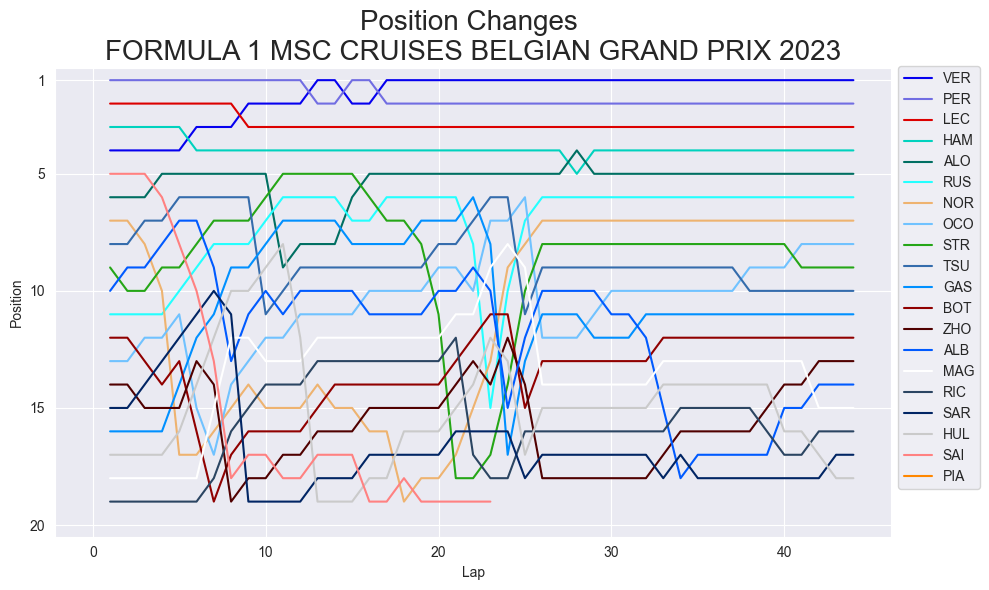

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

for drv in race.drivers:
    drv_laps = race.laps.pick_driver(drv)

    abb = drv_laps['Driver'].iloc[0]

    if abb == 'RIC':
        color = fastf1.plotting.driver_color('DEV')
    else:
        color = fastf1.plotting.driver_color(abb)

    ax.plot(drv_laps['LapNumber'], drv_laps['Position'], label=abb, color=color)

ax.set_ylim([20.5, 0.5])
ax.set_yticks([1, 5, 10, 15, 20])
ax.set_xlabel('Lap')
ax.set_ylabel('Position')    
ax.legend(bbox_to_anchor=(1.0, 1.02))
ax.set_title('Position Changes \n'+race_name, fontsize=20)
plt.tight_layout()
plt.show()

### Laps Time Distribution of Each Driver (Race Pace)

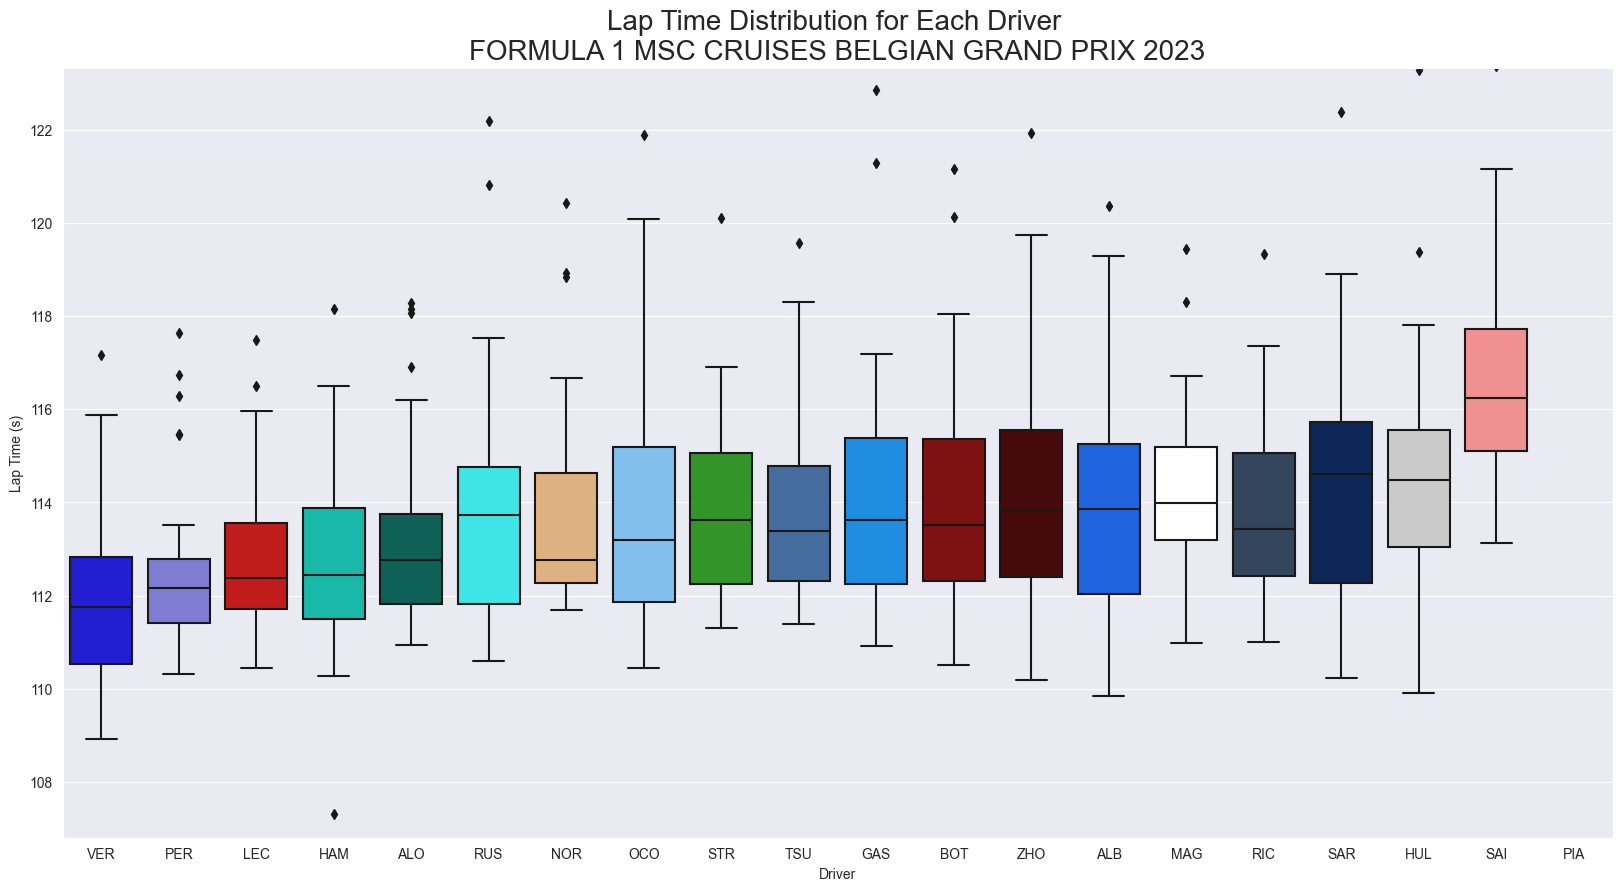

In [27]:
# for color palette
driver_color = {}
for index,lap in df.iterrows():
    driver = lap['Driver']
    if driver == 'RIC':
        driver_color[driver] = fastf1.plotting.driver_color('DEV')
    else:
        driver_color[driver] = fastf1.plotting.driver_color(driver)

# Plot box whisker plots for lap time distribution of each driver
plt.figure(figsize=(20,10))
sns.boxplot(data = df, x = df.Driver, y=df.LapTime, palette=driver_color)
if not rain:
    plt.ylim(min(df.LapTime)-0.5, min(df.LapTime)+10)
else:
    plt.ylim(min(df.LapTime)-0.5, df.LapTime.median()+10)
plt.ylabel('Lap Time (s)')
plt.title('Lap Time Distribution for Each Driver \n'+race_name,  fontsize=20)
plt.show()

### Sector Time Analysis

Text(0.5, 1.0, 'Sector 3')

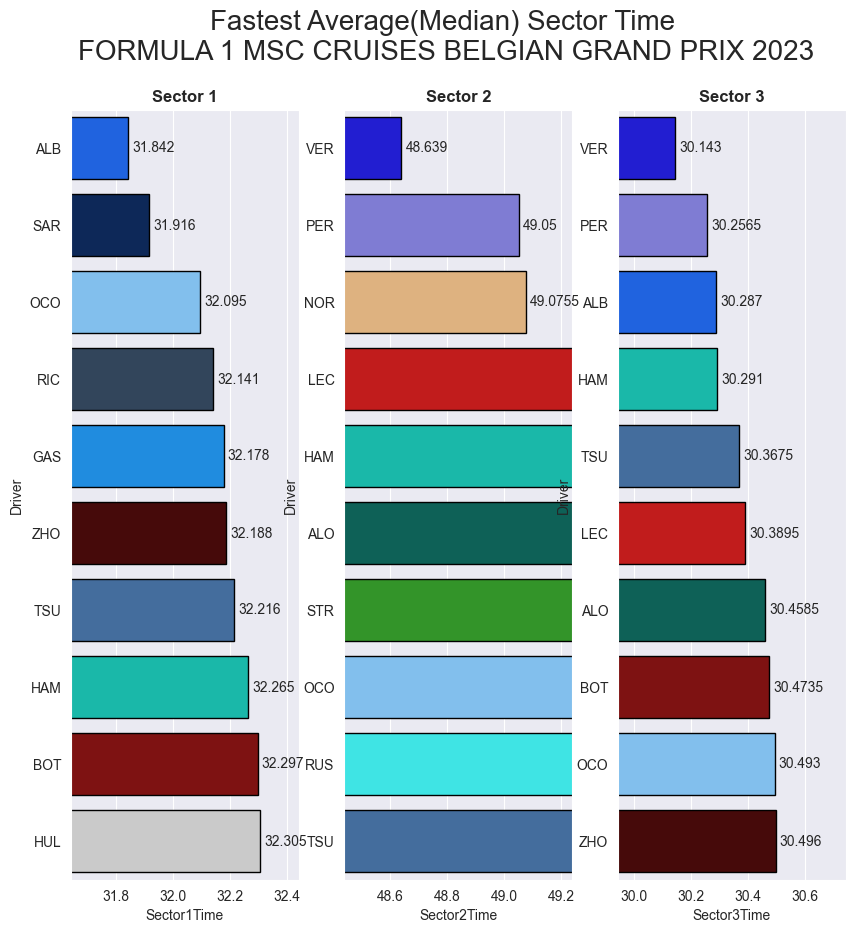

In [28]:
# Get the top 10 fastest average(median) SectorTime
# use median to counter mixed conditions (exp: dry+wet)
top_10_sector1 = df.groupby(['Driver'])['Sector1Time'].median().sort_values().head(10).reset_index()
top_10_sector2 = df.groupby(['Driver'])['Sector2Time'].median().sort_values().head(10).reset_index()
top_10_sector3 = df.groupby(['Driver'])['Sector3Time'].median().sort_values().head(10).reset_index()

fig, ax = plt.subplots(1,3, figsize=(10, 10))
fig.suptitle('Fastest Average(Median) Sector Time \n'+race_name, fontsize=20)

# Sector 1
sns.barplot(x=top_10_sector1['Sector1Time'], y=top_10_sector1['Driver'], palette=driver_color, ax=ax[0], edgecolor='black')
ax[0].bar_label(ax[0].containers[0], padding=3)
ax[0].set_xlim(top_10_sector1.Sector1Time[0]-0.2,top_10_sector1.Sector1Time[0]+0.6)
ax[0].set_title('Sector 1', fontweight="bold")

# Sector 2
sns.barplot(x=top_10_sector2['Sector2Time'], y=top_10_sector2['Driver'], palette=driver_color, ax=ax[1], edgecolor='black')
ax[1].bar_label(ax[1].containers[0], padding=3)
ax[1].set_xlim(top_10_sector2.Sector2Time[0]-0.2,top_10_sector2.Sector2Time[0]+0.6)
ax[1].set_title('Sector 2', fontweight="bold")

# Sector 3
sns.barplot(x=top_10_sector3['Sector3Time'], y=top_10_sector3['Driver'], palette=driver_color, ax=ax[2], edgecolor='black')
ax[2].bar_label(ax[2].containers[0], padding=3)
ax[2].set_xlim(top_10_sector3.Sector3Time[0]-0.2,top_10_sector3.Sector3Time[0]+0.6)
ax[2].set_title('Sector 3', fontweight="bold")

### Lap Time for Top 3 Drivers

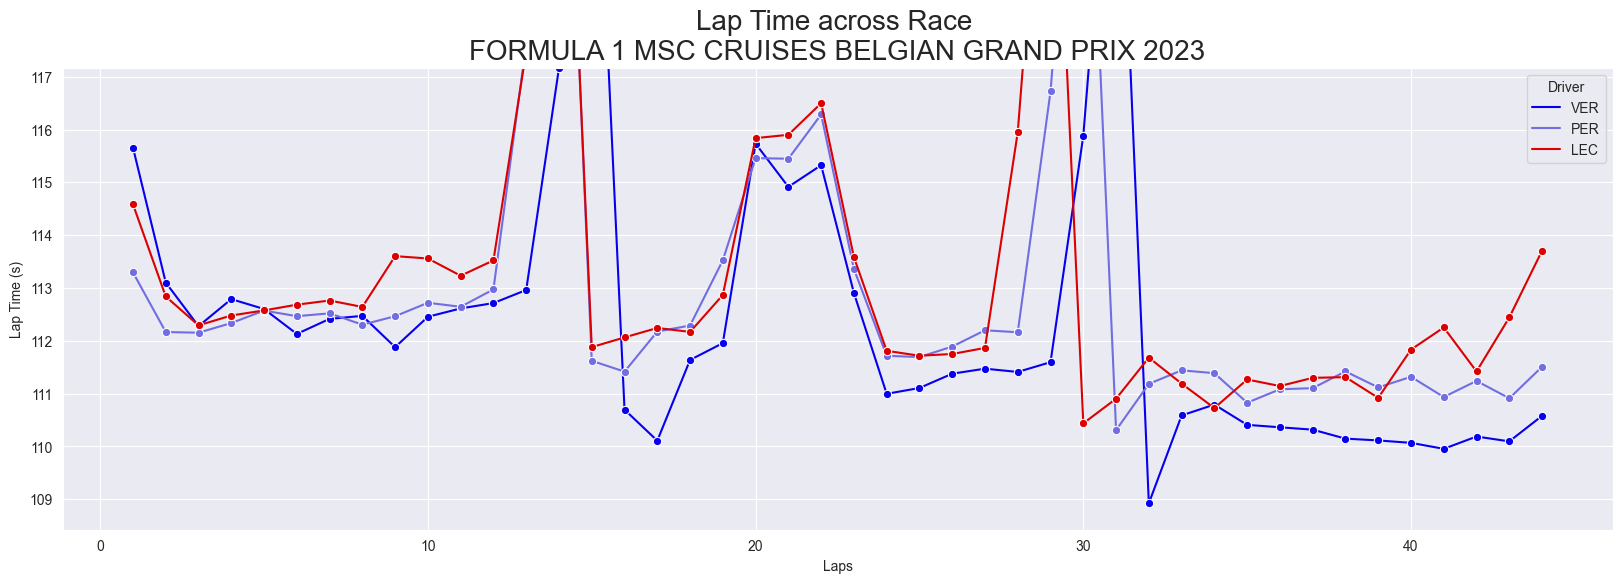

In [29]:
# top 3 Drivers (based on final result)
top_3_drivers = list(race.results.Abbreviation.iloc[:3])

# data cleaning 
df_top3 = df.loc[df.Driver.isin(top_3_drivers),['LapTime','LapNumber','Driver']]
df_top3 = df_top3.reset_index(drop=True)

plt.figure(figsize=(20,6))
sns.lineplot(df_top3, x=df_top3['LapNumber'], y=df_top3['LapTime'], marker = "o", hue=df_top3['Driver'], palette = driver_color)
plt.ylabel('Lap Time (s)')
plt.xlabel('Laps')
plt.title('Lap Time across Race \n'+race_name,  fontsize=20)
if not rain:
    plt.ylim(min(df_top3.LapTime)-0.5, min(df_top3.LapTime)+5)
else:
    plt.ylim(min(df_top3.LapTime)-0.5, df_top3.LapTime.median()+5)
plt.show()

### Tyre Strategy

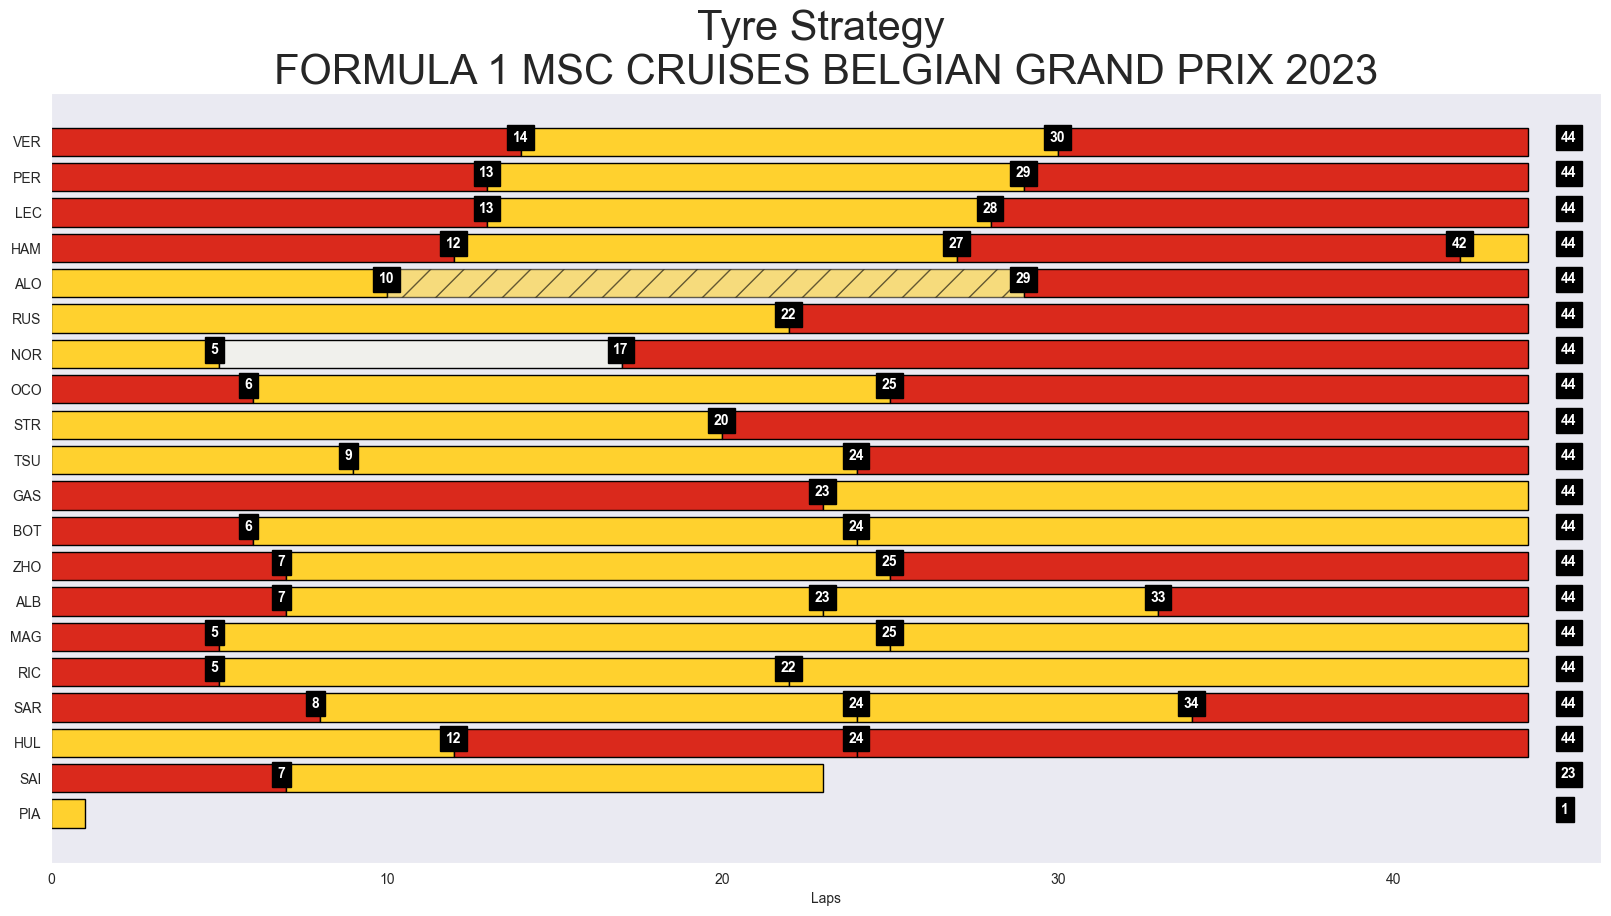

In [39]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.title('Tyre Strategy \n'+race_name,  fontsize=30)
plt.xlabel('Laps')
plt.grid(False)

# Tyre Stint
compound_color = {key: '#'+value for key,value in fastf1.plotting.COMPOUND_COLORS.items()}
tyre_stint = df.groupby(['Driver','Stint','Compound','FreshTyre']).agg({'LapNumber': 'min', 'TyreLife': 'count'}).reset_index()

for drv in list(race.results.Abbreviation)[::-1]:
    driver_stints = tyre_stint[tyre_stint['Driver']== drv]

    for idx, row in driver_stints.iterrows():
        plt.barh(
            y=drv,
            width=row["TyreLife"],
            left=max(row['LapNumber']-1, 0),
            color=compound_color[row.Compound],
            edgecolor="black",
            fill=True,
            # for new/old tyre
            alpha = 0.6 if not row.FreshTyre else 1, hatch = '/' if not row.FreshTyre else None
        )

        if not row['LapNumber'] <= 1.0:
            plt.text(row['LapNumber']-1.25, drv, round(row['LapNumber']-1), fontweight='extra bold', backgroundcolor='black', color = 'white')

    plt.text(df.LapNumber.max()+1, drv, driver_stints['TyreLife'].sum(), fontweight='extra bold', backgroundcolor='black', color = 'white')

### Tyre Degradation

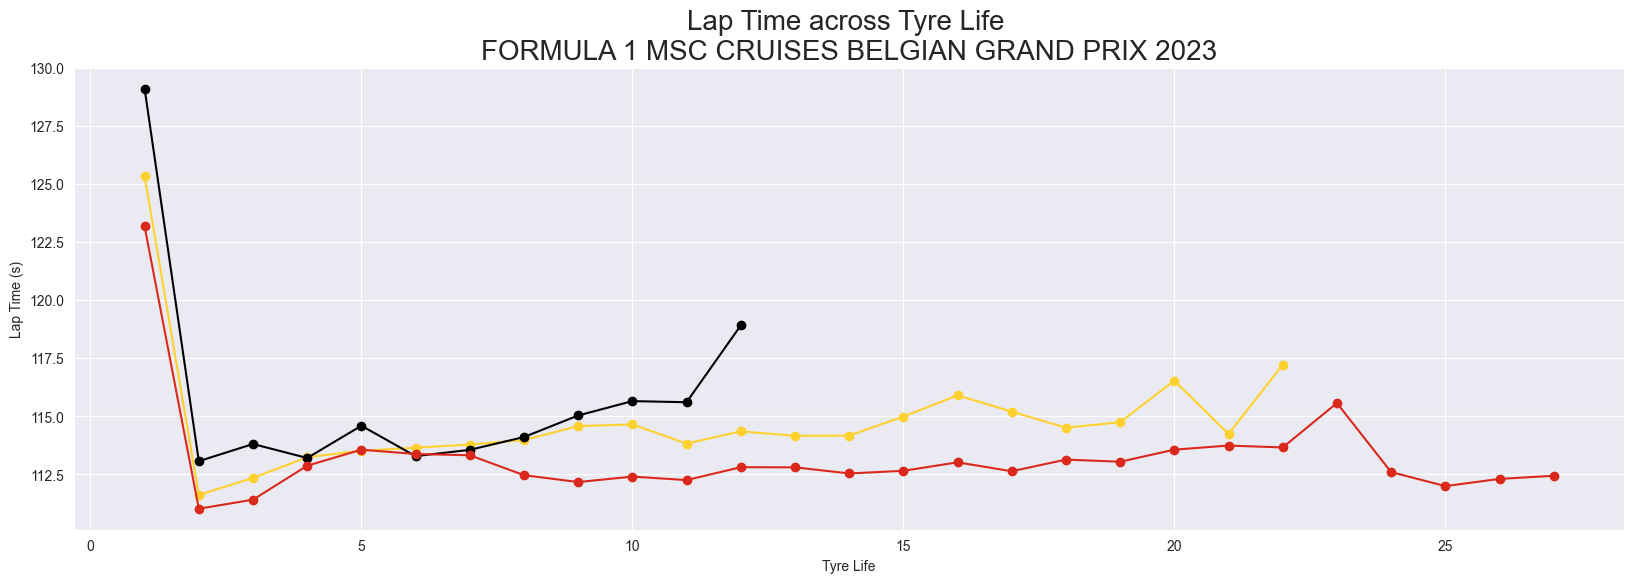

In [40]:
# Get lap times for each driver on each compound
# only selected laptimes with normal track conditions (Track Status = 1)
plt.figure(figsize=(20,6))

for compound in set(df.Compound):
    exec(f"average_laptime_per_tyrelife_{compound} = {{}}")
    data_tyre = df.pick_tyre(compound)
    for tyrelife in range(1,int(data_tyre.TyreLife.max())+1):
        exec(f"average_laptime_per_tyrelife_{compound}[tyrelife] = data_tyre.loc[(df['TyreLife'] == float(tyrelife)) & (df['TrackStatus'] == '1'), ['LapTime']].mean()")
    exec(f"key = average_laptime_per_tyrelife_{compound}.keys()")
    exec(f"value = average_laptime_per_tyrelife_{compound}.values()") 
    color = "#"+fastf1.plotting.COMPOUND_COLORS[compound] if compound != 'HARD' else "000000" # change HARD tyre from white to black
    plt.plot(key, value, color = color, marker='o')

plt.ylabel('Lap Time (s)')
plt.xlabel('Tyre Life')
plt.title('Lap Time across Tyre Life \n'+race_name,  fontsize=20)
if not rain:
    plt.ylim(df.LapTime.median()-3, df.LapTime.median()+3)
plt.show()    


### Average Time Spent on Pit Stops (Team)

Text(0.5, 1.0, 'Average Time Spent on Pit Stops \nFORMULA 1 MSC CRUISES BELGIAN GRAND PRIX 2023\n')

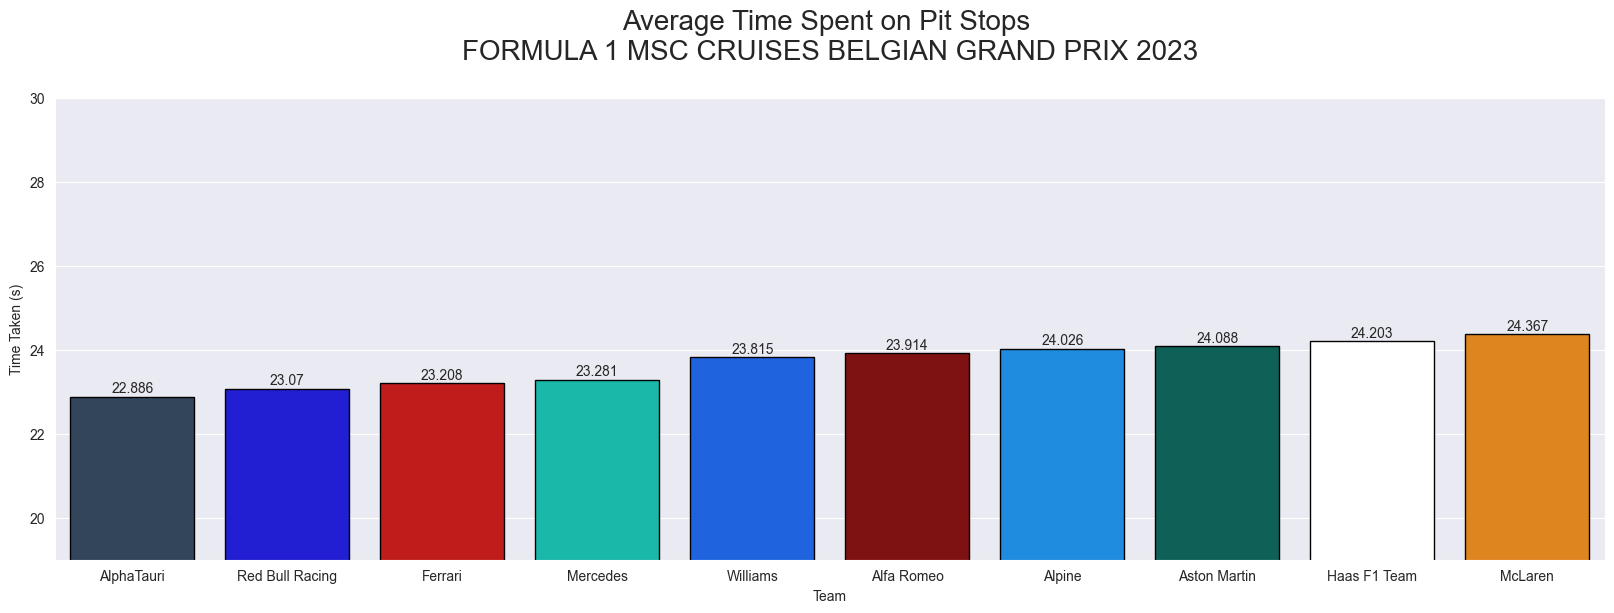

In [32]:
# extract pit enter and exit time
pitstop = df.loc[(df.LapNumber != 1.0) & (df.PitInTime.combine_first(df.PitOutTime).notnull()) , ['Team','Driver','LapNumber','PitOutTime', 'PitInTime']].sort_values(by=['Team','Driver','LapNumber']).reset_index()

# calculate time spent for each pit stop
pitstop['pittime'] = (pitstop.PitOutTime - pitstop.PitInTime.shift(1)).dt.total_seconds()

# aggregrate for each team
pitstop_team_data = pitstop.groupby(['Team'])['pittime'].mean().sort_values().round(3)

# for colour palette
team_color = {}
for team in pitstop_team_data.index:
    team_color[team] = fastf1.plotting.team_color(team)

plt.figure(figsize=(20, 6))
sns.barplot(x=pitstop_team_data.index, y=pitstop_team_data.values, palette=team_color, edgecolor='black')
plt.ylabel('Time Taken (s)')
plt.xlabel('Team')
plt.ylim(19,30)
# to add data labels
for i in range(len(pitstop_team_data)):
    plt.text(i, min(pitstop_team_data[i],30)+0.1, pitstop_team_data[i], ha = 'center')  
plt.title('Average Time Spent on Pit Stops \n'+race_name+'\n',  fontsize=20)

### Total Time Spent on Pit stops (Driver)

Text(0.5, 1.0, 'Total Time Spent on Pit Stops (Driver) \nFORMULA 1 MSC CRUISES BELGIAN GRAND PRIX 2023\n')

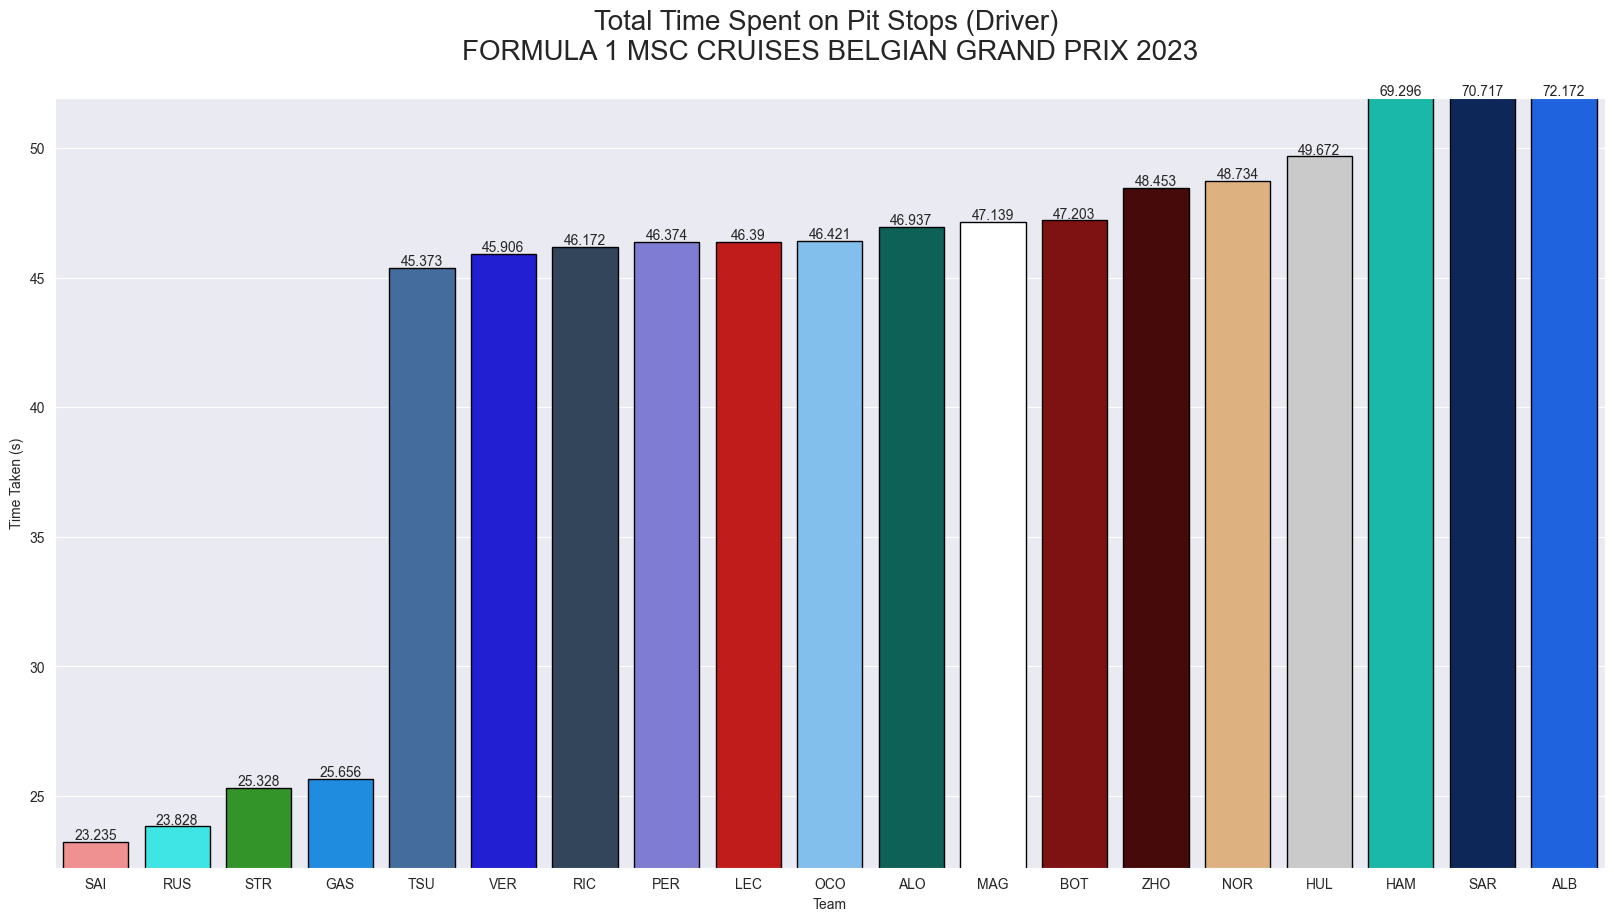

In [33]:
# aggregrate for each driver
pitstop_driver_data = pitstop.groupby(['Driver'])['pittime'].sum().sort_values().round(3)

plt.figure(figsize=(20, 10))
sns.barplot(x=pitstop_driver_data.index, y=pitstop_driver_data.values, palette=driver_color, edgecolor='black')
plt.ylabel('Time Taken (s)')
plt.xlabel('Team')
plt.ylim(pitstop_driver_data[0]-1, pitstop_driver_data[10]+5)
# to add data labels
for i in range(len(pitstop_driver_data)):
    plt.text(i, min(pitstop_driver_data[i],pitstop_driver_data[10]+5)+0.1, pitstop_driver_data[i], ha = 'center')  
plt.title('Total Time Spent on Pit Stops (Driver) \n'+race_name+'\n',  fontsize=20)

### General Weather Data & Track Evolution

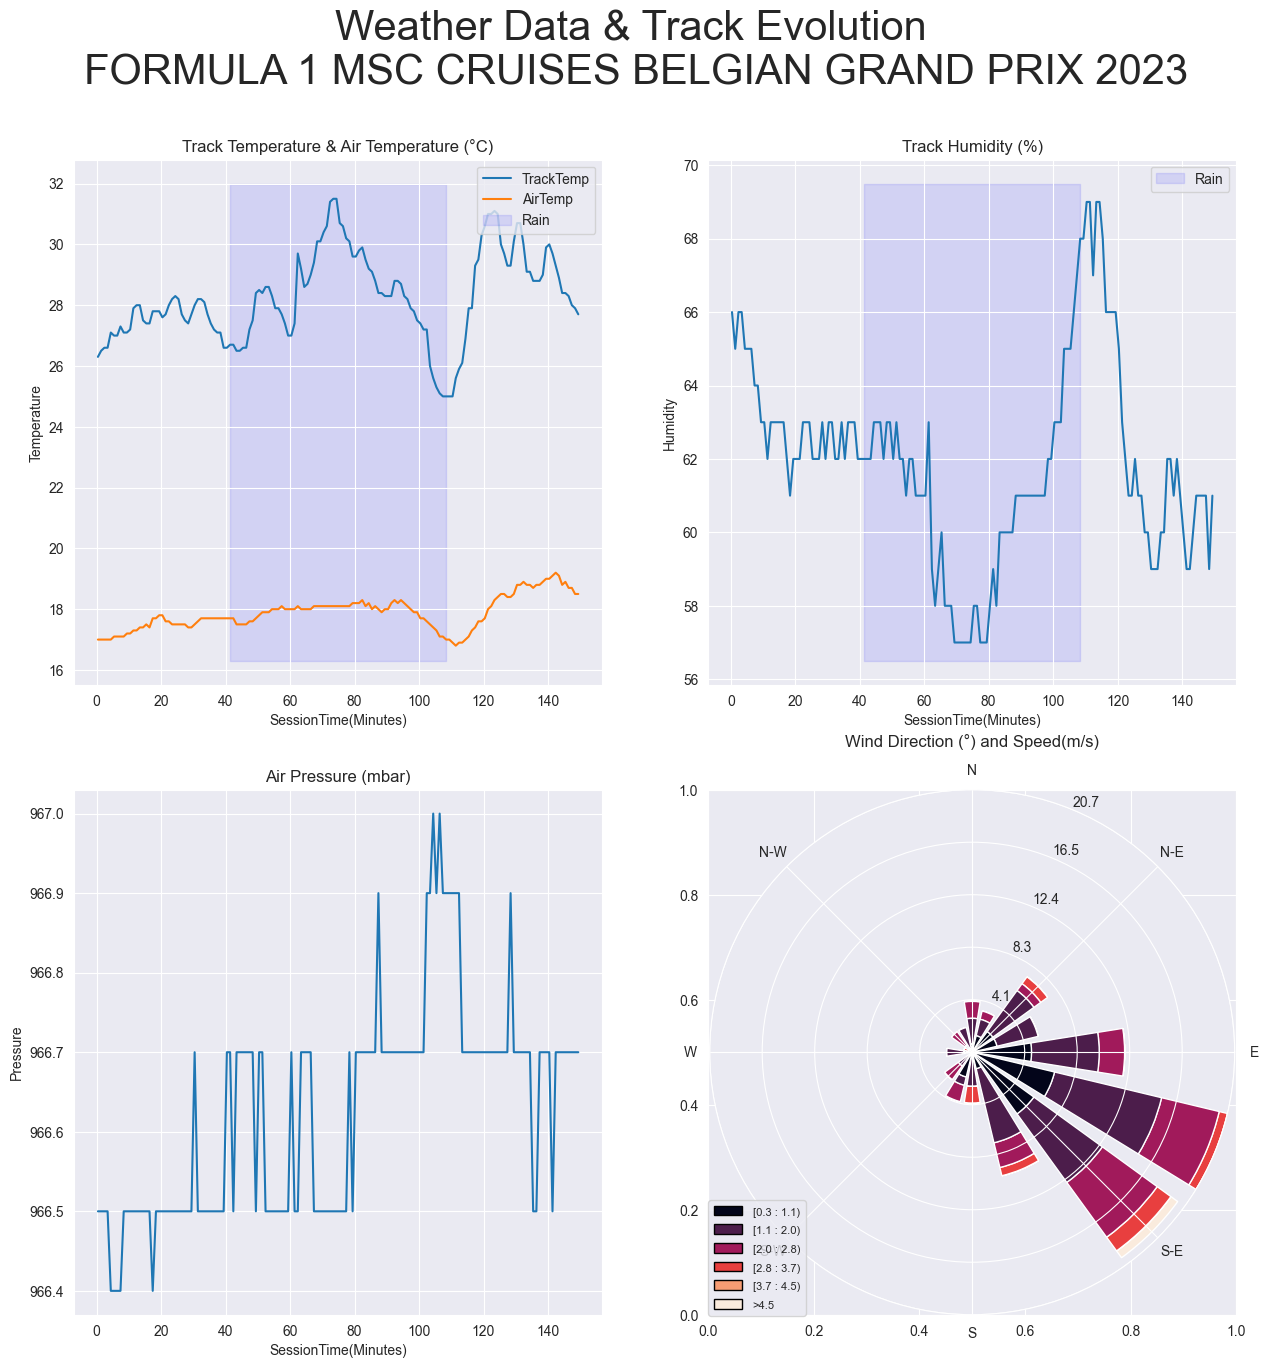

In [34]:
fig, ax = plt.subplots(2,2, figsize=(15, 15))
fig.suptitle('Weather Data & Track Evolution \n'+race_name, fontsize=30)

# Track and Air Temperature
sns.lineplot(data = df_weather, x='SessionTime(Minutes)', y='TrackTemp', label = 'TrackTemp', ax = ax[0,0])
sns.lineplot(data = df_weather, x='SessionTime(Minutes)', y='AirTemp', label = 'AirTemp', ax = ax[0,0])
if rain:
    ax[0,0].fill_between(df_weather[df_weather.Rainfall == True]['SessionTime(Minutes)'], df_weather.TrackTemp.max()+0.5, df_weather.AirTemp.min()-0.5, facecolor="blue", color='blue', alpha=0.1, zorder=0, label = 'Rain')   
ax[0,0].legend(loc='upper right')
ax[0,0].set_ylabel('Temperature')
ax[0,0].title.set_text('Track Temperature & Air Temperature (°C)')

# Humidity
sns.lineplot(df_weather, x='SessionTime(Minutes)', y='Humidity', ax=ax[0,1])
if rain:
    ax[0,1].fill_between(df_weather[df_weather.Rainfall == True]['SessionTime(Minutes)'], df_weather.Humidity.max()+0.5, df_weather.Humidity.min()-0.5, facecolor="blue", color='blue', alpha=0.1, zorder=0, label = 'Rain')   
    ax[0,1].legend(loc='upper right')
ax[0,1].title.set_text('Track Humidity (%)')

# Pressure
sns.lineplot(data = df_weather, x='SessionTime(Minutes)', y='Pressure', ax = ax[1,0])
ax[1,0].title.set_text('Air Pressure (mbar)')

# Wind Direction & Speed
rect = ax[1,1].get_position()
wax = WindroseAxes(fig, rect)
fig.add_axes(wax)
wax.bar(df_weather.WindDirection, df_weather.WindSpeed, normed=True, opening=0.8, edgecolor='white')
wax.set_legend()
ax[1,1].title.set_text('Wind Direction (°) and Speed(m/s)\n\n')